# Setup

In [20]:
# data
import pandas as pd
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

# filters
from pm4py import filter_variants_top_k, filter_start_activities, filter_end_activities, filter_directly_follows_relation, filter_eventually_follows_relation

# process mining
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner

# visualization
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# Laster inn data

In [2]:
df = pd.read_csv('process_mining_data.csv')

In [3]:
df.head()

,case_id,activity,lifecycle,resource,timestamp,amount,article,dismissal,expense,lastsent,matricola,notificationtype,paymentamount,points,totalpaymentamount,vehicleclass,activity_instance_id,.order
0,A1,Create Fine,complete,561.0,2006-07-24,35.0,157.0,NIL,NaN,NaN,NaN,NaN,NaN,0.0,0.0,A,1,1
1,A1,Send Fine,complete,NaN,2006-12-05,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
2,A100,Create Fine,complete,561.0,2006-08-02,35.0,157.0,NIL,NaN,NaN,NaN,NaN,NaN,0.0,0.0,A,3,3
3,A100,Send Fine,complete,NaN,2006-12-12,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4
4,A100,Insert Fine Notification,complete,NaN,2007-01-15,NaN,NaN,NaN,NaN,P,NaN,P,NaN,NaN,NaN,NaN,5,5


# Konverterer pandas df til en event log

For å lage en event log som er lesbar for pm4py-pakken må man gjøre noen transformasjoner og sorteringer. Timestamp må konverteres og sorteres i riktig rekkefølge og nøkkelvariabler må få få nye navn. I dette eksempelet har vi valgt å erstatte originale variabelnavn med de som pakken krever, men man kan også lagre disse som nye variabler hvis man ikke ønsker å erstatte navnene direkte

In [11]:
log = dataframe_utils.convert_timestamp_columns_in_df(df)
log = log.rename(columns={'timestamp': 'time:timestamp', 
                        'case_id': 'case:concept:name', 'activity': 'concept:name', 'resource': 'org:resource'})
log = log.sort_values('time:timestamp')

log = log_converter.apply(log)

In [12]:
log

[{'attributes': {'concept:name': 'A2127'}, 'events': [{'concept:name': 'Create Fine', 'lifecycle': 'complete', 'org:resource': 537.0, 'time:timestamp': Timestamp('2006-06-17 00:00:00+0000', tz='UTC'), 'amount': 35.0, 'article': 157.0, 'dismissal': 'NIL', 'expense': nan, 'lastsent': nan, 'matricola': nan, 'notificationtype': nan, 'paymentamount': nan, 'points': 0.0, 'totalpaymentamount': 0.0, 'vehicleclass': 'A', 'activity_instance_id': 23874, '.order': 23874}, '..', {'concept:name': 'Payment', 'lifecycle': 'complete', 'org:resource': nan, 'time:timestamp': Timestamp('2006-09-17 00:00:00+0000', tz='UTC'), 'amount': nan, 'article': nan, 'dismissal': nan, 'expense': nan, 'lastsent': nan, 'matricola': nan, 'notificationtype': nan, 'paymentamount': 350.0, 'points': nan, 'totalpaymentamount': 35.0, 'vehicleclass': nan, 'activity_instance_id': 23875, '.order': 23875}]}, '....', {'attributes': {'concept:name': 'A22450'}, 'events': [{'concept:name': 'Create Fine', 'lifecycle': 'complete', 'org:

# Process mining maps

## Directly-Follows Graph
Denne type graf viser alle mulige noder og kanter

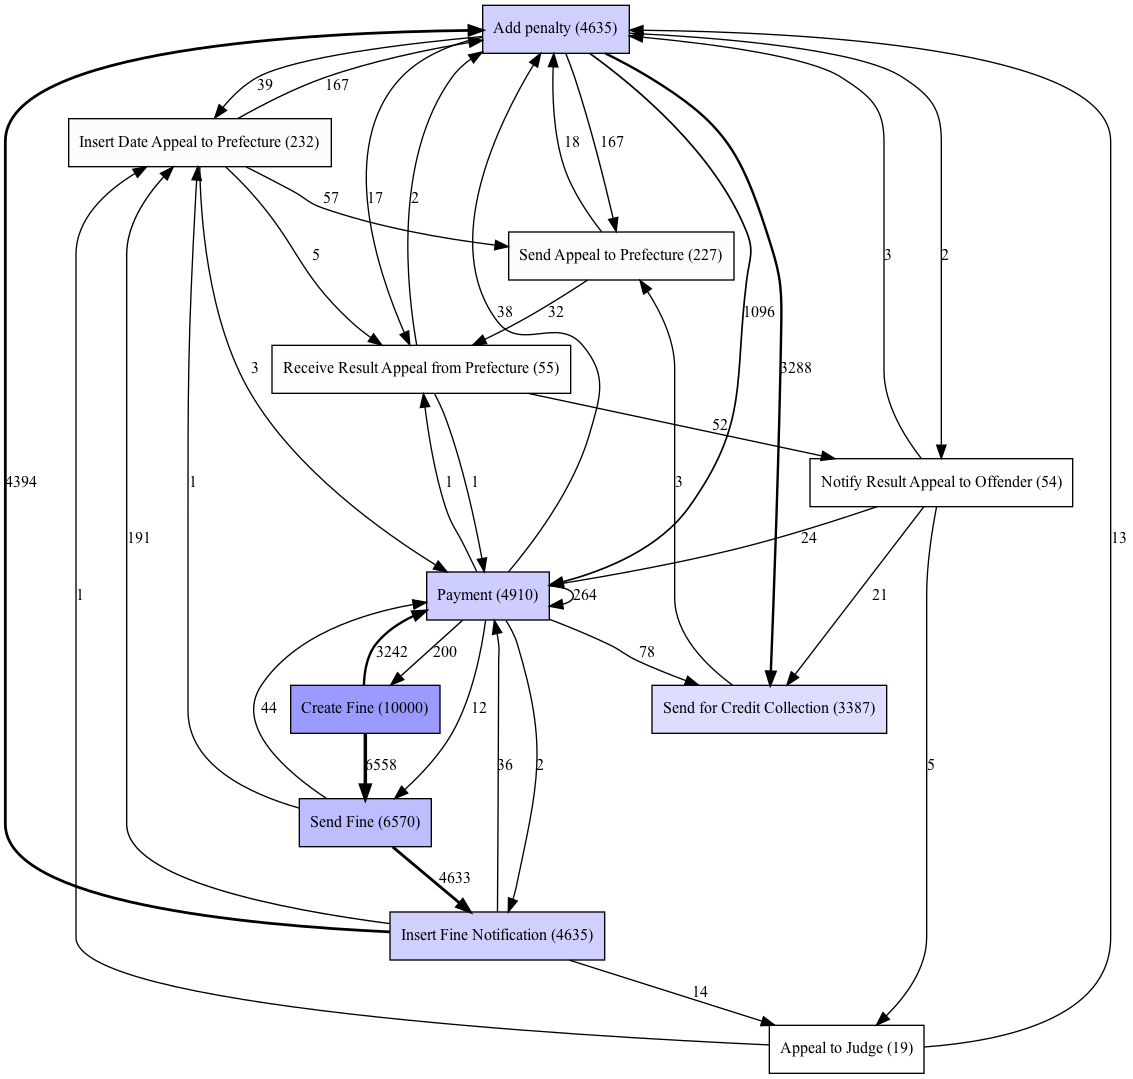

In [13]:
dfg = dfg_discovery.apply(log)
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

Det er også mulig å se gjennomsnittlig tid mellom to eventer

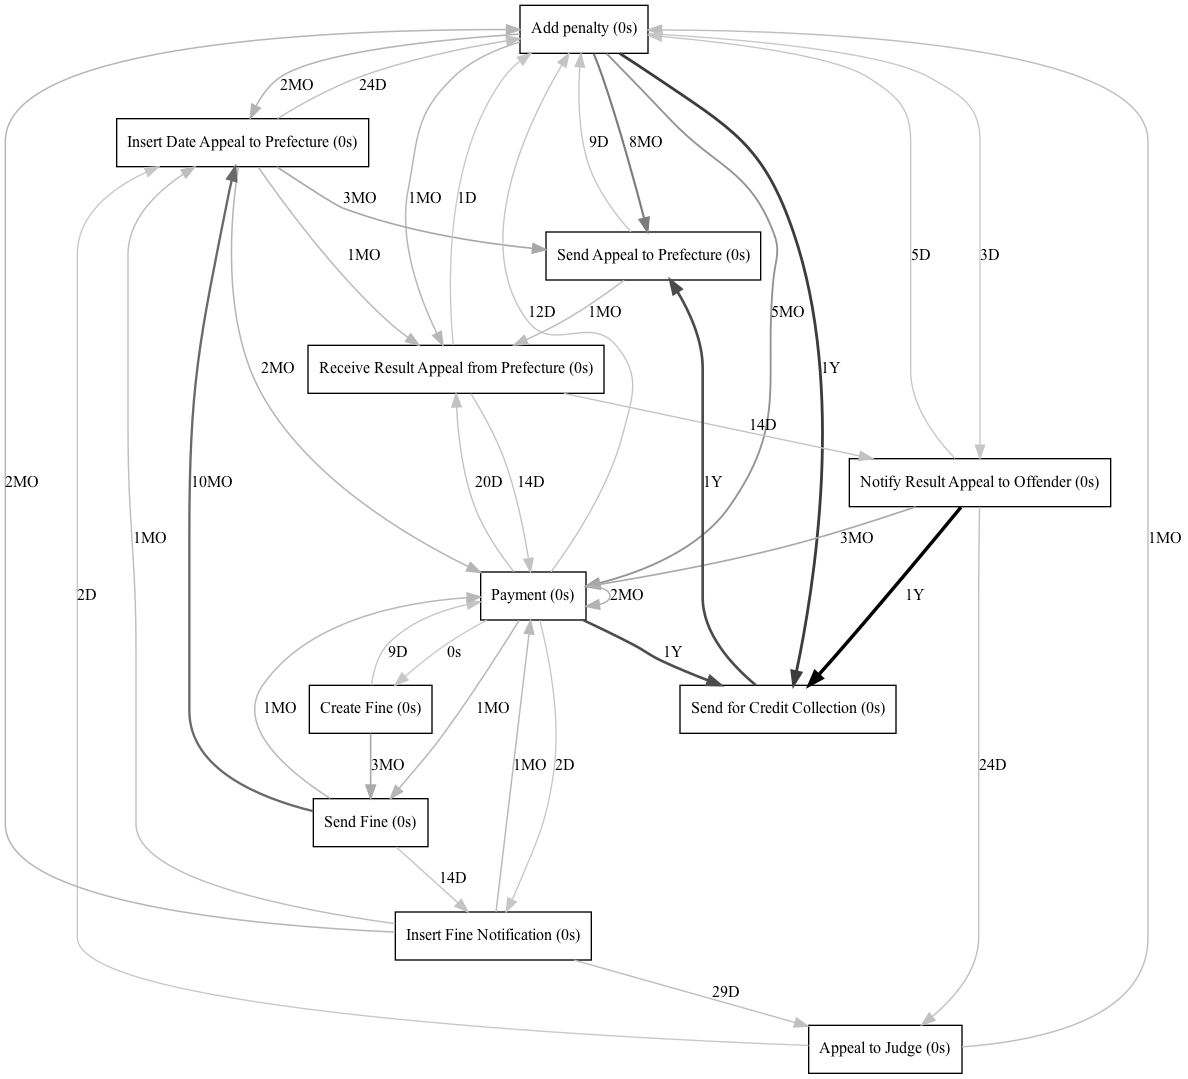

In [17]:
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)

## Heuristics Miner

Heuristic Miner er en av de vanligste algoritmene man kan bruke i Process Mining. Den håndterer støy og klarer å vise den viktigste adferden som er representert i en event log. Plottet nedenfor er laget uten noen form for filtrering og kan ses på som en forenklet representasjon av plottene ovenfor.

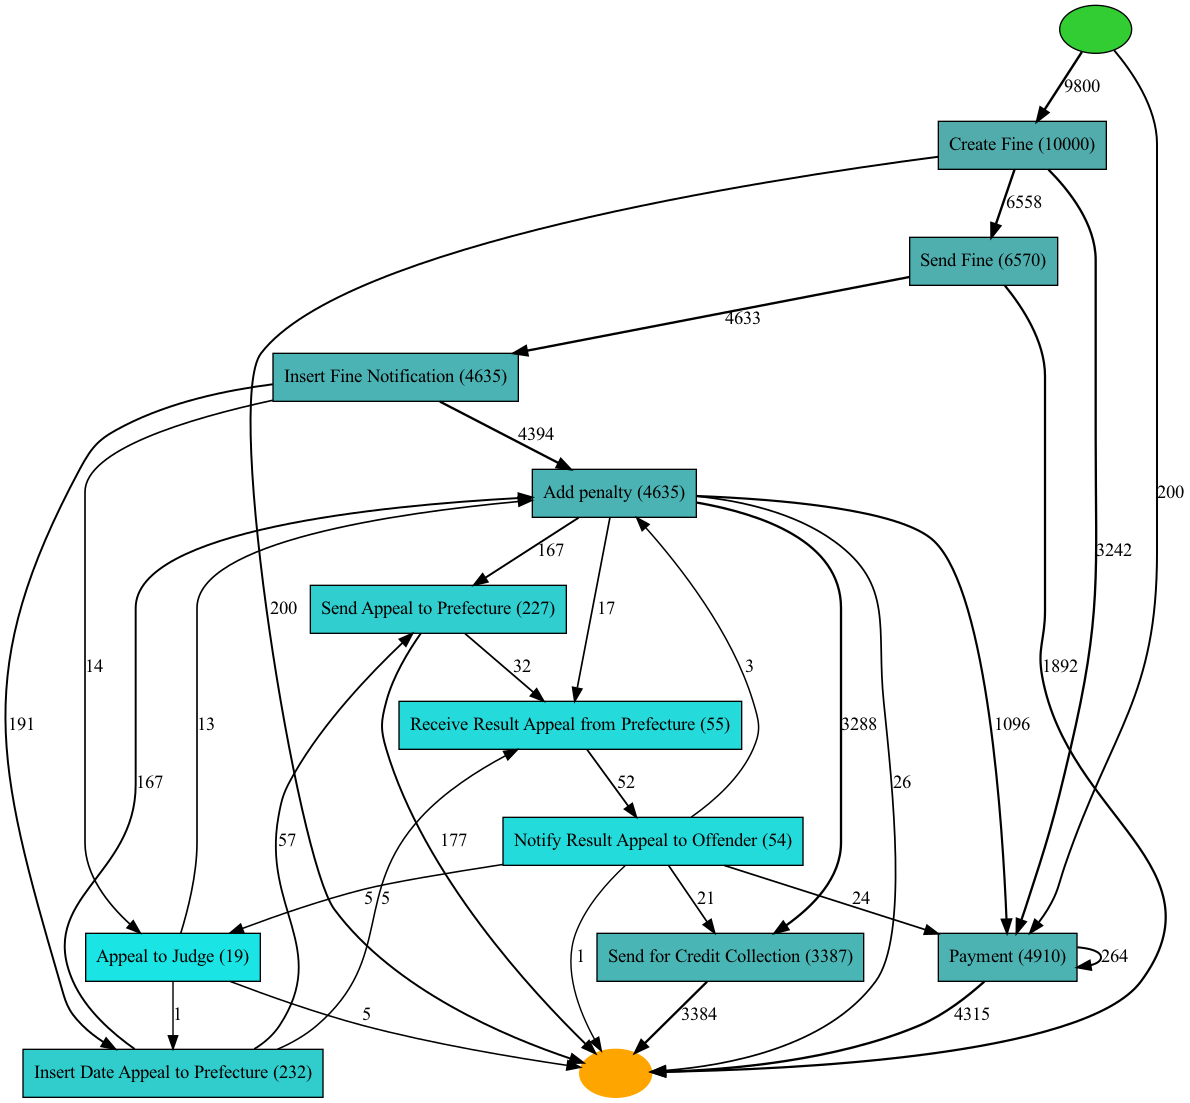

In [10]:
heu_net = heuristics_miner.apply_heu(log)
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

### Ulike typer filtrering med Heuristic Miner

Plottet nedenfor viser en variant hvor vi kun ser på de 3 mest vanlige "prosessene". For å endre antall prosesser man ønsker å se på, kan 3-tallet i første kodelinje erstattes.

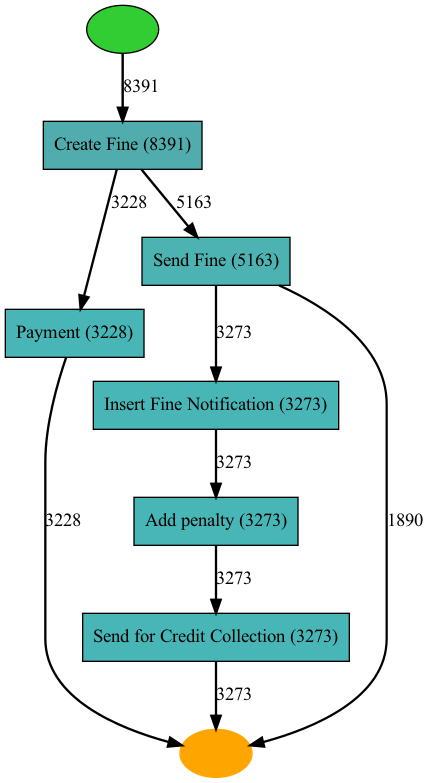

In [18]:
most_common_log = filter_variants_top_k(log, 3)
heu_net = heuristics_miner.apply_heu(most_common_log)
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

I den første grafen med Heuristic Miner ser vi at av 10.000 caser er det 200 som starter med aktiviteten "Payment". For å se kun disse casene kan vi filtrere på start activities. Det er også mulig å filtrere på end activities også. For å gjøre dette må man bytte ut "filter_start_activities" med "filter_end_activities" i første kodelinje. 

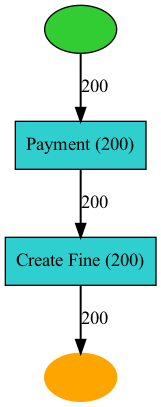

In [22]:
starting_point_log = filter_start_activities(log, {'Payment'})
heu_net = heuristics_miner.apply_heu(starting_point_log)
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

Det er også mulig å filtrere på aktiviteter som enten direkte eller indirekte følger hverandre. I dette eksempelet har vi valgt å filtrere på caser hvor aktiviteten "Send Appeal to Prefecture" følger direkte etter "Add penalty". Det er også mulig å gjøre en indirekte filtrering hvor vi kun sier at "Send Appeal to Prefecture" skal være etter "Add penalty", men nødvendigvis ikke rett etter. Da byttes "filter_directly_follows_relation" i første kodelinje ut med "filter_eventually_follows_relation"

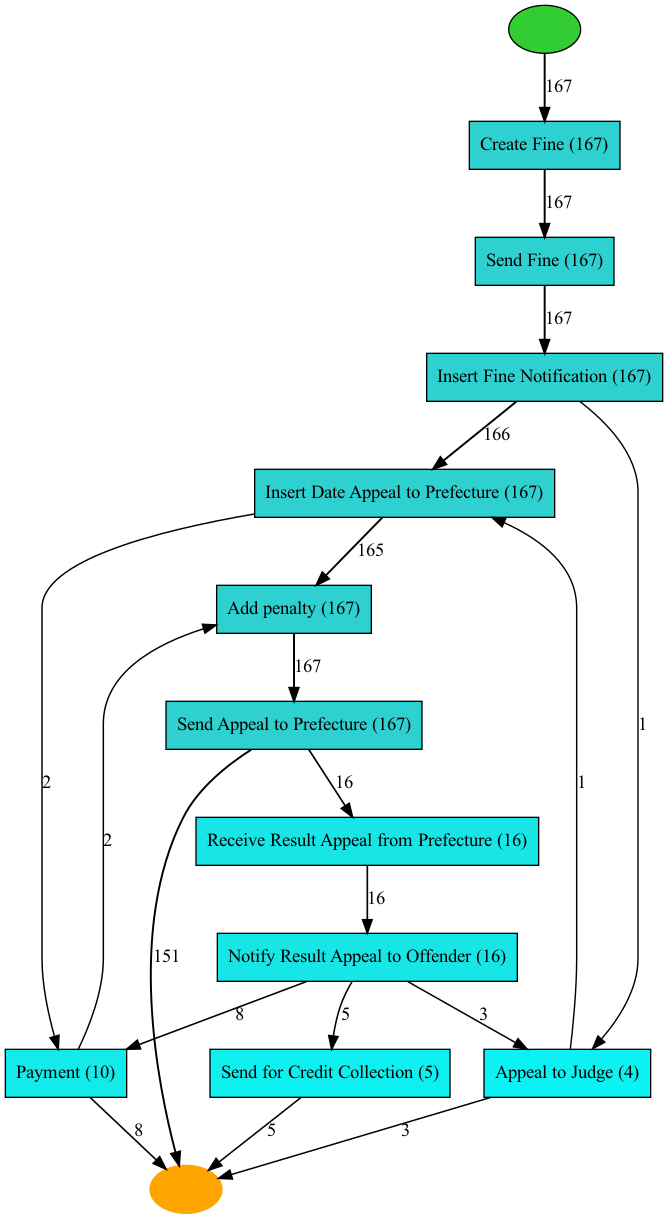

In [26]:
directly_follow_log = filter_directly_follows_relation(log, [('Add penalty', 'Send Appeal to Prefecture')])
heu_net = heuristics_miner.apply_heu(directly_follow_log)
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)